# Sign Language Recognition using MediaPipe and LSTM

This notebook demonstrates the process of building a gesture recognition system using MediaPipe and a Long Short-Term Memory (LSTM) network. The system is designed to recognize a set of predefined gestures performed by a user.

**Workflow:**

1. **Data Acquisition:** We use MediaPipe's Holistic model to extract hand and pose landmarks from videos of different gestures.
2. **Data Preprocessing:** The extracted landmarks are preprocessed and organized into a format suitable for training the LSTM model.
3. **Model Training:** An LSTM network is trained on the preprocessed data to learn the patterns associated with each gesture.
4. **Model Evaluation:** The trained model is evaluated on a separate test set to assess its performance and identify potential areas for improvement.
5. **Model Testing:** The model is tested with a single video to showcase its gesture recognition capabilities.

**Libraries Used:**

* MediaPipe: For hand and pose estimation.
* OpenCV: For image and video processing.
* NumPy: For numerical computations.
* TensorFlow/Keras: For building and training the LSTM model.

**Objectives:**

* To build a sign language recognition system using MediaPipe and LSTM.
* To demonstrate the process of data acquisition, preprocessing, model training, and evaluation.

# Specifying Libraries and Functions

**IMPORTANT:**
Before running this notebook, please make sure to mount your Google Drive to access the necessary files. You can do this by clicking on the "Mount Drive" button in the file explorer on the left.

In [11]:
# !pip install mediapipe==0.10.13
# !pip install opencv-python matplotlib
# !pip install scikit-learn seaborn
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

In [2]:
# Inspect number of files
import os

dataset_base_path = './BIM_Dataset_V3'

if not os.path.exists(dataset_base_path):
    print(f"Error: The directory '{dataset_base_path}' does not exist. Please check the extraction path or the zip file content.")
else:
    all_folders = [f.name for f in os.scandir(dataset_base_path) if f.is_dir()]
    print(f"Total number of folders in '{dataset_base_path}': {len(all_folders)}\n")

    print("Number of files in the first 5 folders:")
    for i, folder_name in enumerate(all_folders):
        if i >= 5:
            break
        folder_path = os.path.join(dataset_base_path, folder_name)
        file_count = len([f for f in os.scandir(folder_path) if f.is_file()])
        print(f"- Folder '{folder_name}': {file_count} files")


Total number of folders in './BIM_Dataset_V3': 90

Number of files in the first 5 folders:
- Folder 'abang': 72 files
- Folder 'ada': 22 files
- Folder 'ambil': 16 files
- Folder 'anak_lelaki': 109 files
- Folder 'anak_perempuan': 73 files


In [3]:
# Save a sample frame
import cv2

video_path = './BIM_Dataset_V3/abang/abang_1_1_1.mp4'
output_frame_path = './sample_frame.jpg'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    cap.set(cv2.CAP_PROP_POS_FRAMES, 30)

    ret, frame = cap.read()

    if ret:
        cv2.imwrite(output_frame_path, frame)
        print(f"Sample frame saved to {output_frame_path}")
    else:
        print(f"Error: Could not read frame from {video_path}")

    cap.release()


Sample frame saved to ./sample_frame.jpg


In [4]:
# Install required libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
# from google.colab.patches import cv2_imshow

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):

    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, lh, rh])



c:\Users\Khor Yin Loon\Desktop\School\sign_language\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


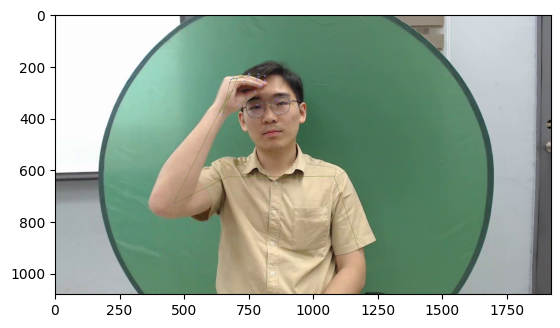

In [5]:
def detect_hand_landmarks(image_path):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Make detections
        image, results = mediapipe_detection(image, holistic)

        # Draw landmarks to the frame
        draw_styled_landmarks(image,results)

        # Convert the image back to BGR for OpenCV
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Display the image with hand landmarks
        plt.imshow(image)


# Testing mediapipe
# Path to your own image file
# image_path = '/content/drive/MyDrive/BIM/frame_28.jpg'
image_path = './sample_frame.jpg'

# Call the function to detect hand landmarks
detect_hand_landmarks(image_path)


In [6]:
# Inspect number of files
import os
import pandas as pd

dataset_base_path = './BIM_Dataset_V3'

if not os.path.exists(dataset_base_path):
    print(f"Error: The directory '{dataset_base_path}' does not exist. Please check the extraction path or the zip file content.")
else:
    all_folders = [f.name for f in os.scandir(dataset_base_path) if f.is_dir()]
    print(f"Total number of folders in '{dataset_base_path}': {len(all_folders)}\n")

    file_count_dict = {}
    for folder_name in all_folders:
        folder_path = os.path.join(dataset_base_path, folder_name)
        file_count_dict[folder_name] = len([f for f in os.scandir(folder_path) if f.is_file()])

df = pd.DataFrame(list(file_count_dict.items()), columns=['Folder Name', 'File Count'])
df_sorted = df.sort_values(by="File Count", ascending=False)
df_sorted.head(30)

Total number of folders in './BIM_Dataset_V3': 90



,Folder Name,File Count
36,hi,399
19,beli,139
75,pukul,133
60,nasi_lemak,122
48,lemak,121
45,kereta,120
59,nasi,119
53,marah,116
3,anak_lelaki,109
13,baik,106


In [8]:
folder_list = df_sorted["Folder Name"].tolist()[:30]
folder_list

['hi',
 'beli',
 'pukul',
 'nasi_lemak',
 'lemak',
 'kereta',
 'nasi',
 'marah',
 'anak_lelaki',
 'baik',
 'jangan',
 'apa_khabar',
 'main',
 'pinjam',
 'buat',
 'ribut',
 'pandai_2',
 'emak_saudara',
 'jahat',
 'panas',
 'assalamualaikum',
 'lelaki',
 'bomba',
 'emak',
 'sejuk',
 'masalah',
 'beli_2',
 'anak_perempuan',
 'perempuan',
 'panas_2']

In [18]:
# Extract few gestures out for training
import os
import shutil

source_base_path = './BIM Dataset V3'
destination_base_path = './train_folder'

folders_to_copy = folder_list

# Create the destination base folder if it doesn't exist
if not os.path.exists(destination_base_path):
    os.makedirs(destination_base_path)
    print(f"Created destination folder: {destination_base_path}")

for folder_name in folders_to_copy:
    source_folder_path = os.path.join(source_base_path, folder_name)
    destination_folder_path = os.path.join(destination_base_path, folder_name)

    if os.path.exists(source_folder_path):
        # If the destination folder already exists, remove it first to ensure a clean copy
        if os.path.exists(destination_folder_path):
            shutil.rmtree(destination_folder_path)
            print(f"Removed existing destination folder: {destination_folder_path}")

        shutil.copytree(source_folder_path, destination_folder_path)
        print(f"Copied '{folder_name}' from '{source_base_path}' to '{destination_folder_path}'")
    else:
        print(f"Source folder '{source_folder_path}' does not exist. Skipping copy for '{folder_name}'.")


Removed existing destination folder: ./train_folder\hi
Copied 'hi' from './BIM Dataset V3' to './train_folder\hi'
Removed existing destination folder: ./train_folder\beli
Copied 'beli' from './BIM Dataset V3' to './train_folder\beli'
Removed existing destination folder: ./train_folder\pukul
Copied 'pukul' from './BIM Dataset V3' to './train_folder\pukul'
Removed existing destination folder: ./train_folder\nasi_lemak
Copied 'nasi_lemak' from './BIM Dataset V3' to './train_folder\nasi_lemak'
Removed existing destination folder: ./train_folder\lemak
Copied 'lemak' from './BIM Dataset V3' to './train_folder\lemak'
Removed existing destination folder: ./train_folder\kereta
Copied 'kereta' from './BIM Dataset V3' to './train_folder\kereta'
Removed existing destination folder: ./train_folder\nasi
Copied 'nasi' from './BIM Dataset V3' to './train_folder\nasi'
Removed existing destination folder: ./train_folder\marah
Copied 'marah' from './BIM Dataset V3' to './train_folder\marah'
Removed exist

In [ ]:
# Specify the path you upload the videos in the Google Drive
video_directory = r'./train_folder'

# Get all file names in the directory
gestures_files = os.listdir(video_directory)

# Specify the gestures
gestures = np.array(gestures_files)
print(gestures)

NameError: name 'np' is not defined

# Data Acquisition
In this part, it process a every gesture videos in the dataset folder to extract and save keypoint data for hand, body, and face landmarks using MediaPipe's Holistic model. For each gesture category, it iterates through associated video files, detects landmarks in up to 30 frames per video, and stores the extracted keypoints in .npy files.

In [20]:
# Specify your path to store landmarks files
train_dataset_path = './train_folder'

for ges in gestures:

    # Specify the video path
    data_path = os.path.join(video_directory, ges)
    data_video = os.listdir(data_path)

    for vid in data_video:

        if not os.path.exists(os.path.join(train_dataset_path)):
            os.makedirs(train_dataset_path)

        landmark_path = os.path.join(train_dataset_path, ges, 'landmarks' + vid)
        video_path = os.path.join(video_directory, ges, vid)
        print(video_path)


        # Locate the video dataset
        video = cv2.VideoCapture(video_path)

        count = 0
        # frame_count = 0

        keypoints_list = []

        # Set mediapipe model
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while True:
                ret, frame = video.read()

                if not ret:
                    # Break the loop if there are no more frames
                    break

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks to the frame
                draw_styled_landmarks(image,results)

                # Check if hands are present
                # This part ensures that only frames with detected hand landmarks are saved.
                if results.left_hand_landmarks or results.right_hand_landmarks:

                    # Create landmark files
                    if not os.path.exists(landmark_path):
                        os.makedirs(landmark_path)

                    # Extract keypoint
                    keypoints = extract_keypoints(results)
                    keypoints_list.append(keypoints)
                #     npy_path = os.path.join(landmark_path, str(count + 1))
                #     np.save(npy_path, keypoints)
                #     print(f"Extract: {npy_path}")

                #     frame_count += 1

                # count += 1

            # standardize AFTER loop
            if len(keypoints_list) >= 30:
                idx = np.linspace(0, len(keypoints_list)-1, 30).astype(int)
                keypoints_list = [keypoints_list[i] for i in idx]
            elif len(keypoints_list) > 0:
                keypoints_list += [keypoints_list[-1]] * (30 - len(keypoints_list))

            # now save exactly 30
            for i, kp in enumerate(keypoints_list):
                npy_path = os.path.join(landmark_path, str(i+1))
                np.save(npy_path, kp)
                print(f"Extract: {npy_path}")


./train_folder\anak_lelaki\anak lelaki_01_01_01.mp4


c:\Users\Khor Yin Loon\Desktop\School\sign_language\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\1
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\2
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\3
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\4
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\5
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\6
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\7
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\8
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\9
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\10
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\11
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\12
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_01_01.mp4\13
Extract: ./train_folder\anak_lelaki\landmarksanak lelaki_01_

KeyboardInterrupt: 

# Data Preprocess and Label

This part processes  landmark files (.npy files) for different gestures stored in the directory. Each gesture is represented as a sequence of landmarks (e.g., coordinates of hands, face, and pose). The goal is to extract these sequences from stored files, organize them into a dataset (gestures_sequence), and pair them with corresponding numeric labels (labels). These labels are generated using a mapping from gesture names to integers (label_map).

### Expected Output
1. [Structure of gestures_sequence] A NumPy array with shape (N, F, L), where:
- N = number of gesture instances (e.g., number of processed videos or data samples).
- F = number of frames per gesture instance (variable depending on the video length).
- L = number of landmarks per frame (for this case 126 landmarks, which are total landmarks of hands, face and pose).

2. [Structure of labels] A NumPy array with shape (N,) containing numeric labels corresponding to the gestures.

In [4]:
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

In [5]:
label_map = {label: num for num, label in enumerate(gestures)}
len(label_map)

30

In [9]:

gesture_sequence, labels = [], []

for gs in gestures:
    gesture = []

    for fname in os.listdir(os.path.join(train_dataset_path, gs)):
        path = os.path.join(train_dataset_path, gs, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(train_dataset_path, gs, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
            print(os.path.join(load_path, npy))

        gesture_sequence.append(video)
        labels.append(label_map[gs])

    # Calculate the maximum sequence length for this gesture
    max_len = max(len(seq) for seq in gesture_sequence)
    min_len = min(len(seq) for seq in gesture_sequence)
    print(f"Gesture: {gs}, Max Length: {max_len}, Min Length: {min_len}")
    
    # Pad shorter sequences with zeros to match the maximum length
    gesture_sequence = [
        seq + [[0] * seq[0].shape[0]] * (max_len - len(seq))  # Pad with zeros
        for seq in gesture_sequence
    ]

    print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save('X_TRAIN_2.npy', X)
np.save('y_TRAIN_2.npy', y)

NameError: name 'train_dataset_path' is not defined

In [24]:
X = np.load('X_TRAIN_2.npy')
y = np.load('y_TRAIN_2.npy')

print(X.shape, y.shape)

(3244, 30, 258) (3244,)


In [15]:
# # Convert the labels into a one-hot encoded format for classification
# # For example, if there are 3 classes, label 1 becomes [0, 1, 0], label 2 becomes [0, 0, 1], etc.
# # y = to_categorical(labels).astype(int)
# labels = np.asarray(labels).reshape(-1, 1)
# enc = OneHotEncoder(sparse_output=False)
# y = enc.fit_transform(labels).astype(int)

# # Split the dataset into training and testing sets
# # - `test_size=0.05`: 5% of the data will be used for testing
# # - The remaining 95% will be used for training
# # - `X_train` and `y_train`: Input features and labels for training
# # - `X_test` and `y_test`: Input features and labels for testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [25]:
y_labels = np.load('y_TRAIN_2.npy').flatten()
# y_labels = np.asarray(labels).flatten()

X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X, y_labels, test_size=0.05, stratify=y_labels, random_state=42
)

# One-hot encode AFTER split
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train_idx.reshape(-1, 1))
y_test = enc.transform(y_test_idx.reshape(-1, 1))

# Training Model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [27]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32   # good starting point (try 16 if dataset is small)

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors and move to the GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.argmax(axis=1), dtype=torch.long).to(device)  # Convert to class indices
y_test = torch.tensor(y_test.argmax(axis=1), dtype=torch.long).to(device)  # Convert to class indices

train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [29]:
# Define your custom LSTM model and move to the GPU
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Create empty lists to store loss and accuracy values
train_losses = []
test_losses = []
test_accuracies = []

input_size = 258
hidden_size = 64
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model on the GPU
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        total_train += yb.size(0)

    avg_train_loss = running_loss / total_train
    loss_history.append(avg_train_loss)

    if (epoch + 1) % 10 == 0:
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.4f}")


# Evaluate the model
model.eval()
correct = 0
total = 0
test_loss_sum = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        outputs = model(xb)
        loss = criterion(outputs, yb)

        test_loss_sum += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

avg_test_loss = test_loss_sum / total
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [10/200] Train Loss: 1.8890
Epoch [20/200] Train Loss: 1.4463
Epoch [30/200] Train Loss: 1.0917
Epoch [40/200] Train Loss: 0.7162
Epoch [50/200] Train Loss: 0.5352
Epoch [60/200] Train Loss: 0.4144
Epoch [70/200] Train Loss: 0.3105
Epoch [80/200] Train Loss: 0.2965
Epoch [90/200] Train Loss: 0.2655
Epoch [100/200] Train Loss: 0.1562
Epoch [110/200] Train Loss: 0.1265
Epoch [120/200] Train Loss: 0.1074
Epoch [130/200] Train Loss: 0.1180
Epoch [140/200] Train Loss: 0.1365
Epoch [150/200] Train Loss: 0.0942
Epoch [160/200] Train Loss: 0.1171
Epoch [170/200] Train Loss: 0.0885
Epoch [180/200] Train Loss: 0.0793
Epoch [190/200] Train Loss: 0.0941
Epoch [200/200] Train Loss: 0.0442
Test Loss: 0.7325, Test Accuracy: 0.9509


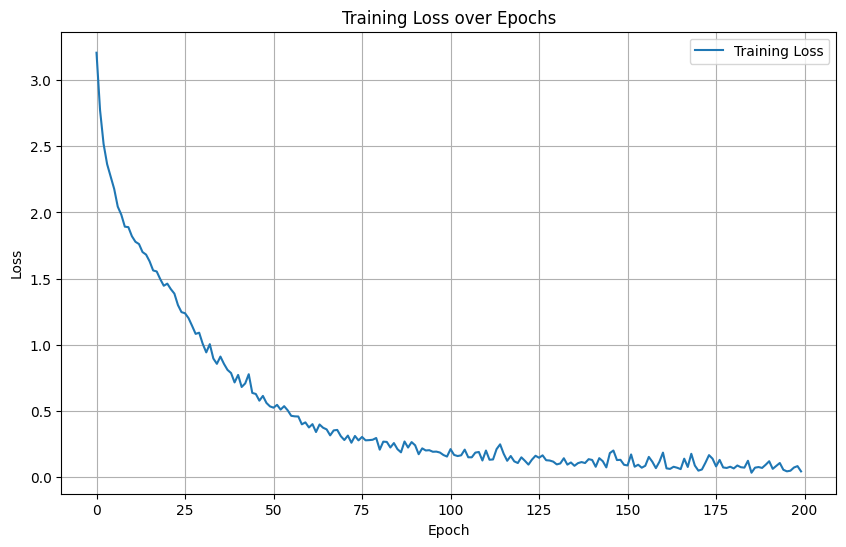

In [30]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Save the trained model
model_filename = 'trained_model.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

Model saved as trained_model.pth


# Model Evaluation

Evaluates the performance of the trained model. The goal is to assess how well the model generalizes to unseen data and identify potential areas for improvement.

**Evaluation Metrics:**

1. **Accuracy:** Measures the overall correctness of the model's predictions.
2. **Confusion Matrix:** Provides a detailed breakdown of the model's predictions, showing the number of true positives, true negatives, false positives, and false negatives for each gesture class.
3. **Classification Report:** Offers a comprehensive overview of the model's performance, including precision, recall, F1-score, and support for each gesture class.

**Visualization:**

* Confusion Matrix Heatmap: A visual representation of the confusion matrix using a heatmap, aiding in understanding the model's performance across different classes.
* Classification Report Heatmap: A heatmap visualizing the classification report, providing a quick overview of key metrics for each class.


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd  # Add this line

Test Loss: 0.7325, Test Accuracy: 0.9509
Confusion Matrix:
[[ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  

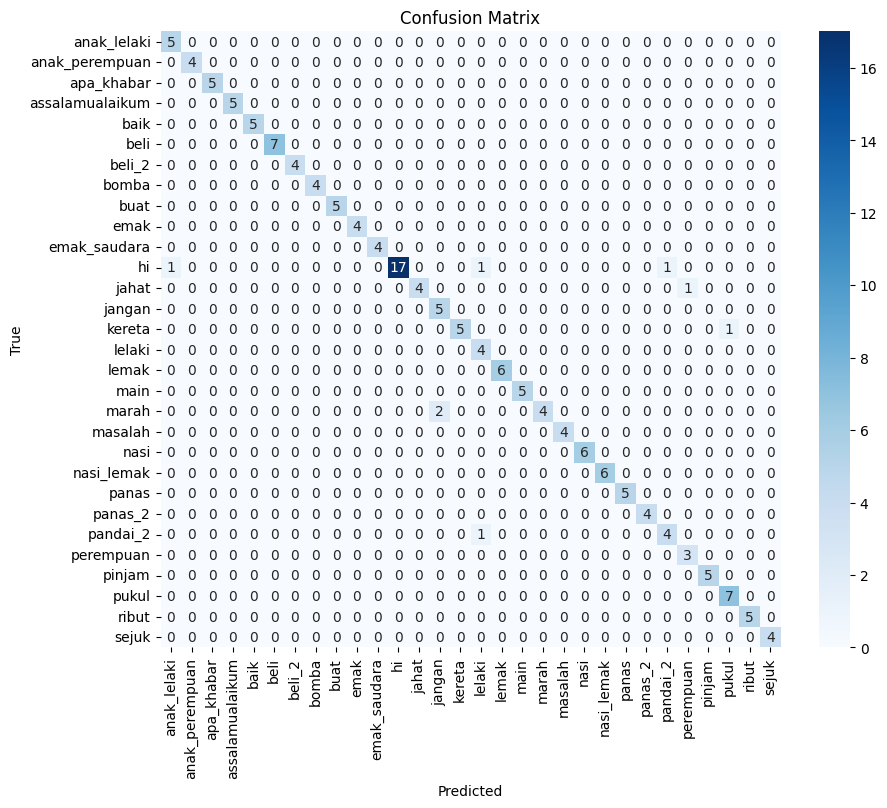

Classification Report:
                 precision    recall  f1-score   support

    anak_lelaki       0.83      1.00      0.91         5
 anak_perempuan       1.00      1.00      1.00         4
     apa_khabar       1.00      1.00      1.00         5
assalamualaikum       1.00      1.00      1.00         5
           baik       1.00      1.00      1.00         5
           beli       1.00      1.00      1.00         7
         beli_2       1.00      1.00      1.00         4
          bomba       1.00      1.00      1.00         4
           buat       1.00      1.00      1.00         5
           emak       1.00      1.00      1.00         4
   emak_saudara       1.00      1.00      1.00         4
             hi       1.00      0.85      0.92        20
          jahat       1.00      0.80      0.89         5
         jangan       0.71      1.00      0.83         5
         kereta       1.00      0.83      0.91         6
         lelaki       0.67      1.00      0.80         4
       

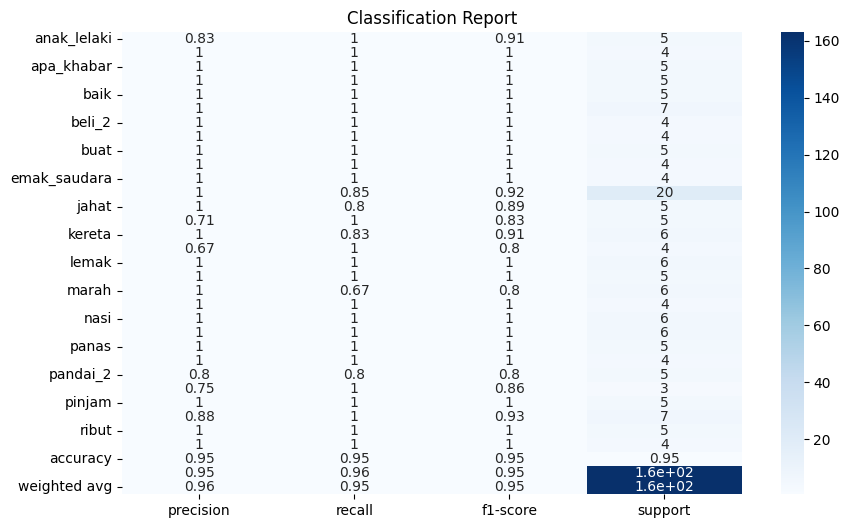

In [32]:
# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

    # Convert predictions and true labels to numpy arrays
    predicted_labels = test_outputs.argmax(dim=1).cpu().numpy()
    true_labels = y_test.cpu().numpy()

    # Calculate and print the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gestures, yticklabels=gestures)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print the classification report
    class_report = classification_report(true_labels, predicted_labels, target_names=gestures)
    print("Classification Report:")
    print(class_report)

    # Plot the classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame.from_dict(classification_report(true_labels, predicted_labels, target_names=gestures, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()




# Model Testing

Testing the model with a single video

In [ ]:
import torch
import torch.nn as nn
import cv2
import os
import numpy as np

# Specify the path you upload the videos in the Google Drive
video_directory = r'./train_folder'

# Get all file names in the directory
gestures_files = os.listdir(video_directory)

# Specify the gestures
gestures = np.array(gestures_files)
print(gestures)

['anak_lelaki' 'anak_perempuan' 'apa_khabar' 'assalamualaikum' 'baik'
 'beli' 'beli_2' 'bomba' 'buat' 'emak' 'emak_saudara' 'hi' 'jahat'
 'jangan' 'kereta' 'lelaki' 'lemak' 'main' 'marah' 'masalah' 'nasi'
 'nasi_lemak' 'panas' 'panas_2' 'pandai_2' 'perempuan' 'pinjam' 'pukul'
 'ribut' 'sejuk']


In [ ]:
# Install required libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
# from google.colab.patches import cv2_imshow

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):

    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=1,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1)
                              )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, lh, rh])



In [ ]:
# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
# input_size = 1662
hidden_size = 64
num_classes = len(gestures)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Load the saved model state dictionary
model_filename = 'trained_model.pth'
loaded_model_state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(loaded_model_state_dict)
model.eval()  # Set the model to evaluation mode

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame


def get_shape(data):
    if not isinstance(data, list):
        return ()
    return (len(data),) + get_shape(data[0])


# 1. New detection variables
sequence = []
sentence = []
predictions = []

# Replace 'video.mp4' with the path to your video file
cap = cv2.VideoCapture('./BIM Dataset V3/baik/baik (II)_01_01_01.mp4')

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Exit loop if video ends
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if results.left_hand_landmarks or results.right_hand_landmarks:
            if len(sequence) == 30:
                res = model(torch.tensor(np.expand_dims(sequence, axis=0), dtype=torch.float32))
                max_val, max_idx = torch.max(res, dim=1)

                # Print prediction result
                print(max_val)
                print(max_idx)
                print(gestures[max_idx])



c:\Users\Khor Yin Loon\Desktop\School\sign_language\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


tensor([20.4676], grad_fn=<MaxBackward0>)
tensor([10])
emak_saudara
tensor([20.0674], grad_fn=<MaxBackward0>)
tensor([10])
emak_saudara
